In [3]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [4]:
pre_df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [5]:
# Create port connections dictionary
port_connections = {}
for i in range(len(pre_df)):
  current_port = pre_df.loc[i, 'place.placeName']
  if i < len(pre_df) - 1:  # Check if next row exists
    next_port = pre_df.loc[i + 1, 'place.placeName']
    if current_port != next_port:  # Avoid self-loops
      if current_port not in port_connections:
        port_connections[current_port] = []
      port_connections[current_port].append(next_port)

# Create directed graph
G = nx.DiGraph()

# Add nodes (ports)
G.add_nodes_from(port_connections.keys())

# Add edges (connections between ports)
for port, connected_ports in port_connections.items():
  for connected_port in connected_ports:
    G.add_edge(port, connected_port)

pos = nx.kamada_kawai_layout(G)

In [6]:
arr = []
for port, connected_ports in port_connections.items():
    arr.append(len(connected_ports))
npArr = np.array(arr)
s = pd.Series(npArr)
print(s.describe())
print(s.quantile(.99))

count    1769.000000
mean       92.784624
std       333.096868
min         1.000000
25%         3.000000
50%        10.000000
75%        52.000000
max      8107.000000
dtype: float64
1449.1599999999992


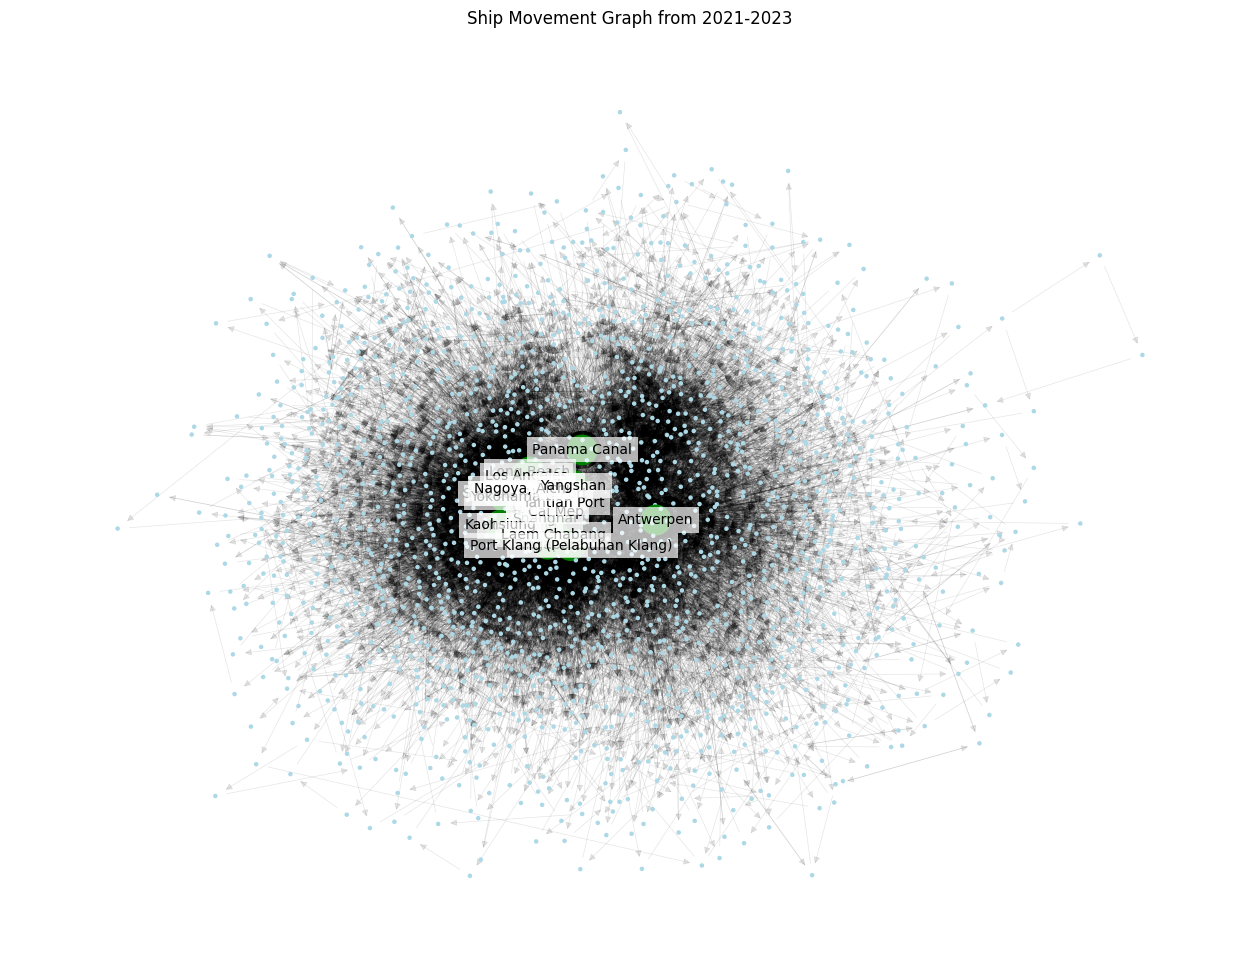

In [7]:
# Assuming G and pos are already defined
plt.figure(figsize=(16, 12))
node_colors = ['green' if len(port_connections[port]) > 1440 else 'lightblue' for port in G.nodes()]
node_sizes = [450 if len(port_connections[port]) > 1440 else 5 for port in G.nodes()]
labels = {node: node if len(port_connections[node]) > 1440 else '' for node in G.nodes()}

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)

# Custom labels with background for better visibility
for node, (x, y) in pos.items():
    if node in labels and labels[node] != '':
        plt.text(x, y, node, fontsize=10, ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title("Ship Movement Graph from 2021-2023")
plt.axis('off')  # Hide axes
plt.show()

In [9]:
df = pd.read_csv("../data/all_vessel_calls.csv")

In [ ]:
df.columns, df.shape

(Index(['arrivalDate', 'sailingDate', 'place.placeName', 'place.unlocode',
        'place.placeType', 'place.countryName', 'Timestamp', 'Event_Type',
        'IMO'],
       dtype='object'),
 (352968, 9))

In [ ]:
code_df = pd.read_csv("../data/unlocode-list.csv", usecols=['Country', 'Location', 'Coordinates'])

In [ ]:
code_df.columns, code_df.shape

(Index(['Country', 'Location', 'Coordinates'], dtype='object'), (116074, 3))

In [ ]:
code_df['place.unlocode'] = code_df['Country'] + code_df['Location']

In [ ]:
code_df.drop_duplicates(subset=['place.unlocode'])

,Country,Location,Coordinates,place.unlocode
0,AD,ALV,4230N 00131E,ADALV
1,AD,CAN,4234N 00135E,ADCAN
2,AD,ENC,4232N 00134E,ADENC
3,AD,ESC,4231N 00133E,ADESC
4,AD,EAC,4233N 00131E,ADEAC
...,...,...,...,...
116069,ZW,STH,1751S 03101E,ZWSTH
116070,ZW,THJ,1800S 02626E,ZWTHJ
116071,ZW,VFA,NaN,ZWVFA
116072,ZW,ZMZ,2016S 03055E,ZWZMZ


In [ ]:
df.dropna(subset=['place.unlocode'])
code_df.dropna(subset=['place.unlocode'])

,Country,Location,Coordinates,place.unlocode
0,AD,ALV,4230N 00131E,ADALV
1,AD,CAN,4234N 00135E,ADCAN
2,AD,ENC,4232N 00134E,ADENC
3,AD,ESC,4231N 00133E,ADESC
4,AD,EAC,4233N 00131E,ADEAC
...,...,...,...,...
116069,ZW,STH,1751S 03101E,ZWSTH
116070,ZW,THJ,1800S 02626E,ZWTHJ
116071,ZW,VFA,NaN,ZWVFA
116072,ZW,ZMZ,2016S 03055E,ZWZMZ


In [ ]:
merged_df = df.merge(code_df, on='place.unlocode')
# merged_df

In [ ]:
morning_champ_df = merged_df[merged_df['IMO'] == 9285627]
glovis_sonic_df =  merged_df[merged_df['IMO'] == 9798387]

In [ ]:
# visualize morning_champ_df
# convert coordinates
morning_champ_df[morning_champ_df['Coordinates'].isnull()]['place.placeName'].unique(), morning_champ_df[morning_champ_df['Coordinates'].isnull()]['place.unlocode'].unique()

(array([], dtype=object), array([], dtype=object))

In [ ]:
# convert coordinates - seperate them into lat and log
morning_champ_df['lat'] = morning_champ_df['Coordinates'].apply(lambda x: x.split(' ')[0] if x else None)
morning_champ_df['lon'] = morning_champ_df['Coordinates'].apply(lambda x: x.split(' ')[1] if x  else None)
# # convert coordinates - read direction
morning_champ_df['lat'] = morning_champ_df['lat'].apply(lambda x: '-' + x[:-1] if x[-1:] == 'S' else x[:-1])
morning_champ_df['lon'] = morning_champ_df['lon'].apply(lambda x: '-' + x[:-1] if x[-1:] == 'W' else x[:-1])
# morning_champ_df

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_4832\729755320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_champ_df['lat'] = morning_champ_df['Coordinates'].apply(lambda x: x.split(' ')[0] if x else None)
C:\Users\SyeAli\AppData\Local\Temp\ipykernel_4832\729755320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_champ_df['lon'] = morning_champ_df['Coordinates'].apply(lambda x: x.split(' ')[1] if x  else None)
C:\Users\SyeAli\AppData\Local\Temp\ipykernel_4832\729755320.py:5: SettingWi

In [ ]:
# convert to float with the last two digits being decimal points
def handle_lat_lon(x):
    if x:
        if '-' in x:
            return float(x[:-2]) + float(x[0] + x[-2:])/100
        else:
            return float(x[:-2]) + float(x[-2:])/100
    return None


morning_champ_df['lat'] = morning_champ_df['lat'].apply(lambda x: handle_lat_lon(x))
morning_champ_df['lon'] = morning_champ_df['lon'].apply(lambda x: handle_lat_lon(x))
# print(morning_champ_df.to_string())

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_4832\309023157.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_champ_df['lat'] = morning_champ_df['lat'].apply(lambda x: handle_lat_lon(x))
C:\Users\SyeAli\AppData\Local\Temp\ipykernel_4832\309023157.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_champ_df['lon'] = morning_champ_df['lon'].apply(lambda x: handle_lat_lon(x))


In [ ]:
morning_champ_df = morning_champ_df.reset_index(drop=True)
morning_champ_df = morning_champ_df.sort_values(by='Timestamp')

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import numpy as np

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_4832\298761877.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


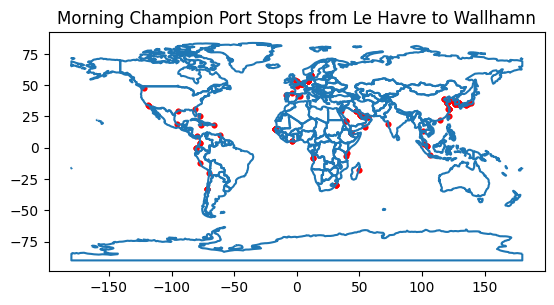

In [ ]:
# lines = []
# for i in range(len(morning_champ_df) - 1):
#   start_point = (morning_champ_df.loc[i, 'lon'], morning_champ_df.loc[i, 'lat'])
#   end_point = (morning_champ_df.loc[i + 1, 'lon'], morning_champ_df.loc[i + 1, 'lat'])
#   line = LineString([start_point, end_point])

#   lines.append(line)

# # print(lines)
# gdf_lines = geopandas.GeoDataFrame({'geometry': lines})

# Plotting (adjust world and styles as needed)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.boundary.plot()
# gdf_lines.plot(ax=ax, color='darkblue', linewidth=2, linestyle='--')  # Line color and width


# Plot ship positions at ports (adjust marker and color)
gdf_morning_champ = geopandas.GeoDataFrame(morning_champ_df, geometry=geopandas.points_from_xy(morning_champ_df.lon, morning_champ_df.lat))
gdf_morning_champ.plot(ax=ax, marker='o', color='red', markersize=10)  # Marker style, color, and size
# Title and display
plt.title("Morning Champion Port Stops from " + morning_champ_df.iloc[0]['place.placeName'] + 
          " to " + morning_champ_df.iloc[-1]['place.placeName'])
plt.show()

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_4832\694128092.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


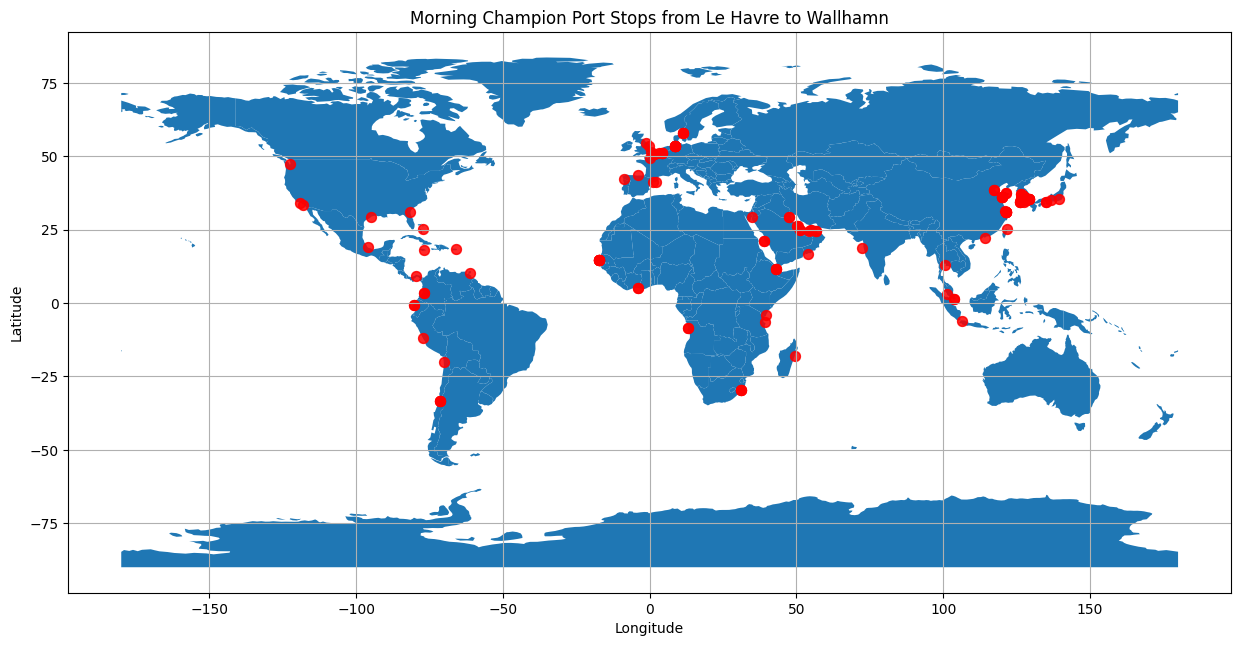

In [ ]:
# Load world map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(15, 10))

# Plot ship positions at ports
gdf_morning_champ = geopandas.GeoDataFrame(morning_champ_df,
                                           geometry=geopandas.points_from_xy(morning_champ_df.lon, morning_champ_df.lat))
gdf_morning_champ.plot(ax=ax, marker='o', color='red', markersize=50, alpha=0.6)


plt.title("Morning Champion Port Stops from " + morning_champ_df.iloc[0]['place.placeName'] +
          " to " + morning_champ_df.iloc[-1]['place.placeName'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_4832\8594516.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


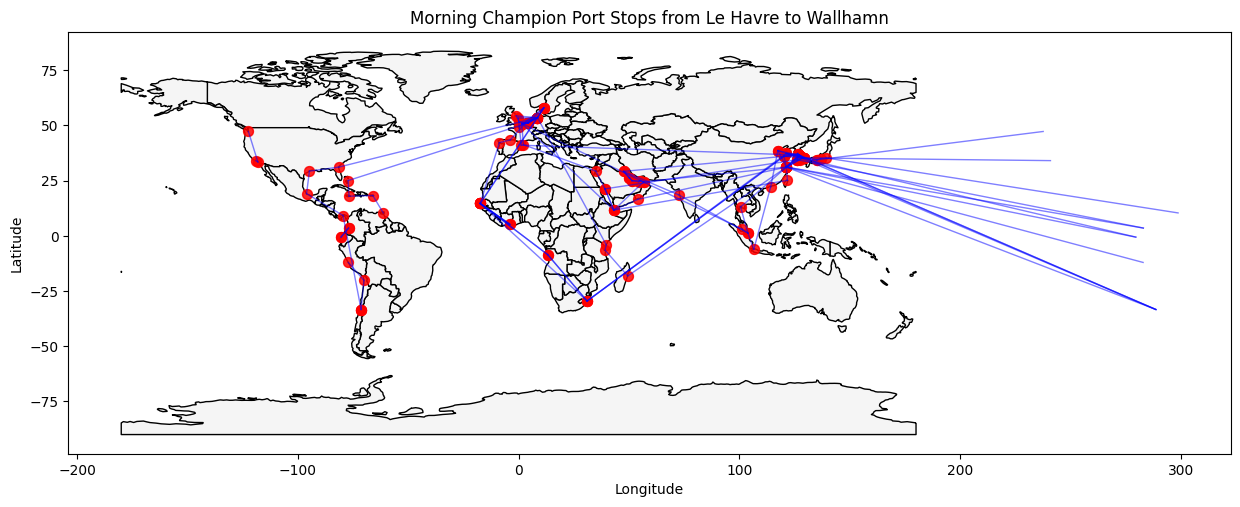

In [ ]:
# Load world map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(15, 10), color='whitesmoke', edgecolor='black')

# Create GeoDataFrame for ship positions
gdf_morning_champ = geopandas.GeoDataFrame(morning_champ_df,
                                           geometry=geopandas.points_from_xy(morning_champ_df.lon, morning_champ_df.lat))

# Plot ship positions at ports
gdf_morning_champ.plot(ax=ax, marker='o', color='red', markersize=50, alpha=0.6)

# Function to create great circle lines
def create_great_circle(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    if abs(lon2 - lon1) > 180:  # adjust for International Date Line crossing
        if lon1 < 0:
            lon1 += 360
        else:
            lon2 += 360
    num_segments = 100
    line = LineString([Point(lon1, lat1), Point(lon2, lat2)])
    if line.length > 200:  # arbitrary threshold to skip long lines across the map
        return None
    return np.array([np.linspace(lon1, lon2, num_segments), np.linspace(lat1, lat2, num_segments)])

# Draw great circle routes between ports
for i in range(len(gdf_morning_champ) - 1):
    coord1 = gdf_morning_champ.geometry.iloc[i].coords[0]
    coord2 = gdf_morning_champ.geometry.iloc[i + 1].coords[0]
    gc_coords = create_great_circle(coord1, coord2)
    if gc_coords is not None:
        ax.plot(gc_coords[0], gc_coords[1], linestyle='-', linewidth=1, color='blue', alpha=0.5)

# Title and display
plt.title("Morning Champion Port Stops from " + morning_champ_df.iloc[0]['place.placeName'] +
          " to " + morning_champ_df.iloc[-1]['place.placeName'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

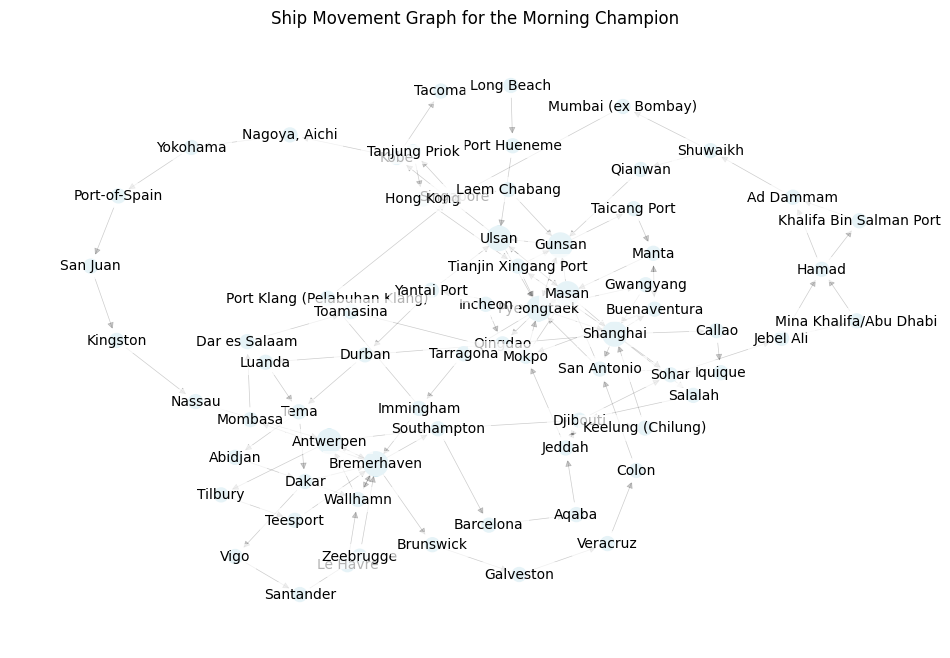

In [ ]:
# Create port connections dictionary
port_connections = {}
for i in range(len(morning_champ_df)):
  current_port = morning_champ_df.loc[i, 'place.placeName']
  if i < len(morning_champ_df) - 1:  # Check if next row exists
    next_port = morning_champ_df.loc[i + 1, 'place.placeName']
    if current_port != next_port:  # Avoid self-loops
      if current_port not in port_connections:
        port_connections[current_port] = []
      port_connections[current_port].append(next_port)

# Create directed graph
G = nx.DiGraph()

# Add nodes (ports)
G.add_nodes_from(port_connections.keys())

# Add edges (connections between ports)
for port, connected_ports in port_connections.items():
  for connected_port in connected_ports:
    G.add_edge(port, connected_port)

pos = nx.kamada_kawai_layout(G)

# Assuming G and pos are already defined
plt.figure(figsize=(12, 8))
node_colors = ['lightgreen' if port == 'Starting Port' else 'red' if port == 'Ending Port' else 'lightblue' for port in G.nodes()]
node_sizes = [300 if len(port_connections[port]) > 3 else 100 for port in G.nodes()]
labels = {node: node if len(port_connections[node]) > 3 or node in ['Starting Port', 'Ending Port'] else '' for node in G.nodes()}

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

# Custom labels with background for better visibility
for node, (x, y) in pos.items():
    if node in labels:
        plt.text(x, y, node, fontsize=10, ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title("Ship Movement Graph for the Morning Champion")
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
import plotly.graph_objects as go

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # color scale options
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_trace.text = [node for node in G.nodes()]

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network Graph representing the ports visited by the Morning Champion',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [ ]:
import plotly.graph_objects as go

edge_trace = []
node_trace = go.Scatter(x=[], y=[], hoverinfo='text', mode='markers+text', marker=dict(size=[], color=[]), text=[], textposition='top center')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace.append(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                                 mode='lines', line=dict(width=0.5, color='blue'), hoverinfo='none'))
    # Add arrowheads
    arrow_size = 0.03
    edge_trace.append(go.Scatter(x=[x1, x1 - arrow_size * (x1 - x0)], y=[y1, y1 - arrow_size * (y1 - y0)],
                                 mode='lines', line=dict(width=0.5, color='blue'), hoverinfo='none'))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    connections = len(G.edges(node))
    node_trace['marker']['size'] += tuple([5 + connections * 2])  # Dynamic size based on connections
    node_trace['marker']['color'] += tuple(['red' if connections > 2 else 'blue'])  # Color based on connection count
    node_trace['text'] += tuple([node if connections > 2 else ''])  # Only show labels for highly connected ports

fig = go.Figure(data=edge_trace + [node_trace],
                layout=go.Layout(title='Network Graph representing the ports visited by the Morning Champion', showlegend=False,
                                 hovermode='closest', margin={'b': 20, 'l': 5, 'r': 5, 't': 40},
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_4832\1134874594.py:7: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



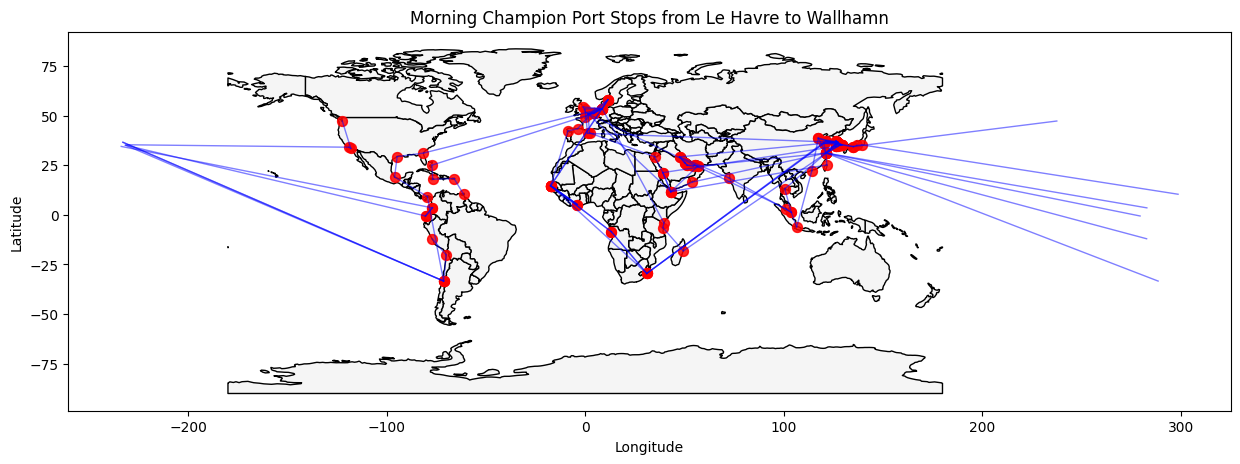

In [ ]:
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import numpy as np

# Load world map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(15, 10), color='whitesmoke', edgecolor='black')

# Function to normalize longitude values
def normalize_longitude(lon):
    if lon > 180:
        lon -= 360
    elif lon < -180:
        lon += 360
    return lon

# Create GeoDataFrame for ship positions
morning_champ_df['lon'] = morning_champ_df['lon'].apply(normalize_longitude)
gdf_morning_champ = geopandas.GeoDataFrame(morning_champ_df,
                                           geometry=geopandas.points_from_xy(morning_champ_df.lon, morning_champ_df.lat))

# Plot ship positions at ports
gdf_morning_champ.plot(ax=ax, marker='o', color='red', markersize=50, alpha=0.6)

# Function to create great circle lines that avoid crossing the map edge
def create_great_circle(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    if abs(lon1 - lon2) > 180:
        lon2 = lon2 - 360 if lon2 > 0 else lon2 + 360
    num_segments = 100
    return np.array([np.linspace(lon1, lon2, num_segments), np.linspace(lat1, lat2, num_segments)])

# Draw great circle routes between ports
for i in range(len(gdf_morning_champ) - 1):
    coord1 = gdf_morning_champ.geometry.iloc[i].coords[0]
    coord2 = gdf_morning_champ.geometry.iloc[i + 1].coords[0]
    gc_coords = create_great_circle(coord1, coord2)
    ax.plot(gc_coords[0], gc_coords[1], linestyle='-', linewidth=1, color='blue', alpha=0.5)

# Title and display
plt.title("Morning Champion Port Stops from " + morning_champ_df.iloc[0]['place.placeName'] +
          " to " + morning_champ_df.iloc[-1]['place.placeName'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()